# Using Optimal Control to get an exponentialy decaying Magnetization

In [184]:
%matplotlib inline

import numpy as np
from scipy.stats import norm


import sigpy as sp
import sigpy.mri as mr
import sigpy.mri.rf as rf
import sigpy.plot as pl
import scipy.signal as signal
import scipy.io as sio
import matplotlib.pyplot as plt

#### Define Parameters:

Amplitude : gmag=1.000000 G/cm
Duration RF Pulse: N*dt=2.500000ms
Amplitude : gmag_Hzcm=4257.000000 Hz/cm
Amplitude : gmag_kHzcm=0.042570 kHz/cm
dib=1.436962
ftwb=0.179620


Text(0.5, 1.0, 'Weight * desired profile vs. x[m]')

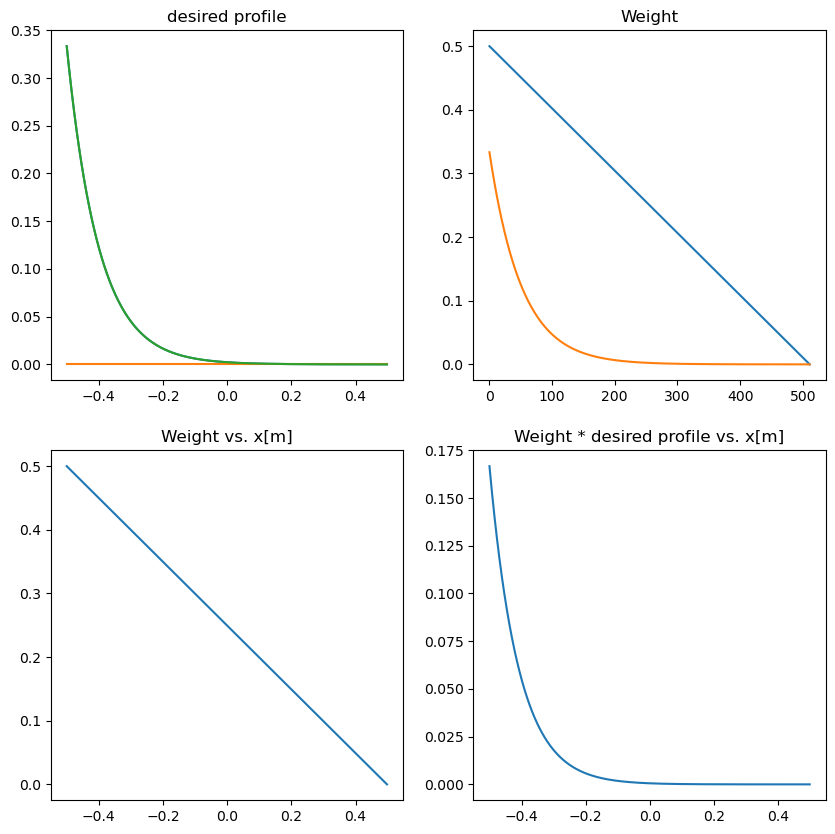

In [412]:
%matplotlib inline

N = 256
tb = 8 # npoints in pulse, tb of pulse

os = 2 # spatial oversampling factor
d1 = 0.01
d2 = 0.01 # ripple levels in beta profile

T = 2.5*1e-3 # seconds, RF Pulse duration
dt = T/N # seconds, sampling rate

dthick = 4 * 1e-1 # slice thickness in cm

# set mag of gamgdt according to tb + dthick
gambar = 4257 # Hz/G
# gmag = tb/(N*dt)/dthick/gambar # G/cm
gmag = 1 # G/cm
gmag_Hzcm = gmag * gambar # Hz / cm
gmag_kHzcm = gmag_Hzcm / 1000.0 / 100.0  # kHz / cm

print("Amplitude : gmag=%f G/cm" %gmag)
print("Duration RF Pulse: N*dt=%fms" %(N*dt*1000.0))
print("Amplitude : gmag_Hzcm=%f Hz/cm" %(gmag_Hzcm))
print("Amplitude : gmag_kHzcm=%f kHz/cm" %(gmag_kHzcm))


# get spatial locs + gradient
x = np.arange(0,N*os,1)/N/os-1/2

# gradient:
gamgdt = 2*np.pi*gambar*gmag*dt*np.ones(N)

# set gradient to 0:
# gamgdt = np.zeros_like(gamgdt)

# set up target beta pattern
d1 = np.sqrt(d1/2) # Mxy -> beta ripple for ex pulse
d2 = d2/np.sqrt(2)
dib = rf.slr.dinf(d1,d2);

ftwb = dib/tb;
fb = np.asarray([0, (1-ftwb)*(tb/2), (1+ftwb)*(tb/2), N/2])/N; # freq edges, normalized to 2*nyquist
print("dib=%f" %dib)
print("ftwb=%f" %ftwb)

dpass = np.abs(x) < fb[1] # passband mask
dstop = np.abs(x) > fb[2] # stopband mask
wb = [1, d1/d2]



# Weights:
# -----------------------------
w = dpass + wb[1]/wb[0]*dstop # 'points we care about' mask
w = np.ones_like(dpass)
w = np.zeros_like(dpass)
# w[int(len(w)/2):-1] = 1
w[0:int(len(w)/4)] = 1
w = np.ones_like(w)
w = np.linspace(10, 0, 2*N)
w = w / np.sum(w) * N / 2.0


# Magnetization profile:
# -----------------------------
# db = np.sqrt(1/2)*dpass*np.exp(-1j/2*x*2*np.pi) # target beta pattern

# Gaussian:
# db = norm.pdf(x,0,0.05)
# db = db / np.max(db) / 2.0

# exponential:
db = np.exp(-np.linspace(0, 2*N-1, 2*N)/(2*N-1) / 0.1)
# db = np.fft.fftshift(db)
db = db / np.max(db) / 3.0



plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(x,np.real(db))
plt.plot(x,np.imag(db))
plt.plot(x,np.abs(db))
plt.title('desired profile')
plt.subplot(2,2,2)
plt.plot(w)
plt.plot(np.abs(db))
plt.title('Weight')
plt.subplot(2,2,3)
plt.plot(x,w)
plt.title('Weight vs. x[m]')
plt.subplot(2,2,4)
plt.plot(x,w*np.abs(db))
plt.title('Weight * desired profile vs. x[m]')


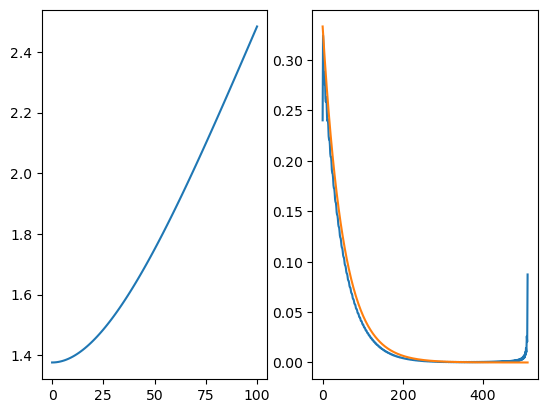

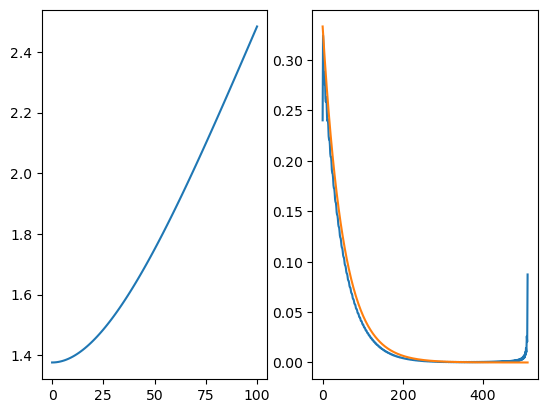

In [413]:
from IPython import display

# small function to calculate the cost:
def cost_calcer(pulse_shape_desired=None, pulse_shape_result=None, a=0, b=0):
    if pulse_shape_result is None:
        pulse_shape_result = 2*np.conj(a)*b
    diff = pulse_shape_result- pulse_shape_desired    
    return diff

# init parameters:

stepsize = 0.0001
iters = 100

# init empty arrays:
pulse = np.zeros(N, dtype=complex)
a = np.exp(1j/2*x/(gambar*dt*gmag)*np.sum(gamgdt))
b = np.zeros(a.shape, dtype=complex)

eb = b - db

cost = np.zeros(iters+1)
cost[0] = np.real(np.sum(w*np.abs(eb)**2))

# plot parameters:
fig, axlist = plt.subplots(1,2)
pass_yes_no = True

# Iterate
for ii in range(0, iters, 1):
    # abortion criterium
    if pass_yes_no == True:
        # calculate search direction
        
        # magnitude
        auxb = w*(b - db)
        
        # angle?
        auxa = w*(a - np.angle(db))
        auxa = None
        drf = rf.optcont.deriv(pulse, x/(gambar*dt*gmag), gamgdt, 0, auxb, a, b)
        # was like that before, better results without
        # drf = 1j*np.imag(drf)
        
        # get test point
        pulse -= stepsize*drf
        
        # simulate test point
        [a,b] = rf.optcont.blochsim(rf=pulse, x=x/(gambar*dt*gmag), g=gamgdt)
        
        # calculate difference
        eb = b - db
        # new way:
        eb = cost_calcer(pulse_shape_desired=db,
                         pulse_shape_result=None,
                         a=a,
                         b=b)

        # calulate cost:
        cost[ii+1] = np.sum(w*np.abs(eb)**2)
        # print(cost[ii]-cost[ii+1])

        # plotting:--------------------------------------------------------------
        axlist[0].clear()
        axlist[0].plot(cost)

        
        Mxy = 2*np.conj(a)*b
        Mxy_inv = np.fft.fftshift(np.fft.fft(Mxy))
        Mxy_approx = np.fft.ifftshift(np.fft.fftshift(np.fft.ifft(Mxy_inv)))
        
        axlist[1].clear()
        axlist[1].plot(np.abs(Mxy_approx))
        axlist[1].plot(np.abs(db))

        #ax1.title("diff cost = %f.5, %d / %d" %(cost[ii]-cost[ii+1], ii, iters))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        # plotting:--------------------------------------------------------------

        # check if cost differene is above threshold:
        # if abs(cost[ii]-cost[ii+1]) > 1e-5:
        #     pass_yes_no = True
        # else:
        #     pass_yes_no = False




#### Plot Results:

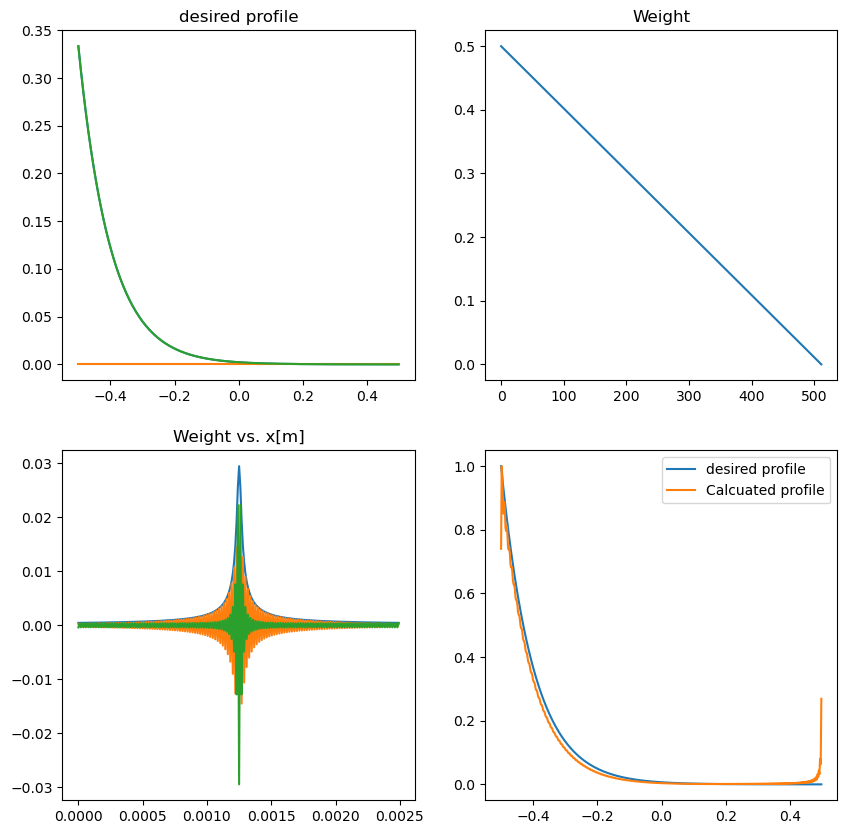

In [414]:


plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(x,np.real(db),label='real')
plt.plot(x,np.imag(db),label='imaginary')
plt.plot(x,np.abs(db),label='Magnitude')
plt.title('desired profile')
plt.subplot(2,2,2)
plt.plot(w)
plt.title('Weight')
plt.subplot(2,2,3)
plt.plot(np.linspace(0,(N-1)*dt,N), np.abs(pulse))
plt.plot(np.linspace(0,(N-1)*dt,N), np.real(pulse))
plt.plot(np.linspace(0,(N-1)*dt,N), np.imag(pulse))
plt.title('Weight vs. x[m]')
plt.subplot(2,2,4)
Mxy = 2*np.conj(a)*b
plt.plot(x,np.abs(db)/np.max(np.abs(db)),label='desired profile')
plt.plot(x,np.abs(Mxy)/np.max(np.abs(Mxy)),label='Calcuated profile')
plt.legend()


In [415]:
# Open the file in write mode ('w')
import numpy as np
import scipy.io

array = pulse
array = array/np.max(array) * 100.0
# Save to .mat file
scipy.io.savemat('block_pulse.mat', {'rfpulse': array})


#### Now using constant weights:

Amplitude in G/cm: gmag=2.303012
Amplitude in Hz/cm: gmag_kHzcm=9803.921569
Pulse duration: N*dt=1.020000
dib=1.436962
ftwb=0.035924


Text(0.5, 1.0, 'Weight * desired profile vs. x[m]')

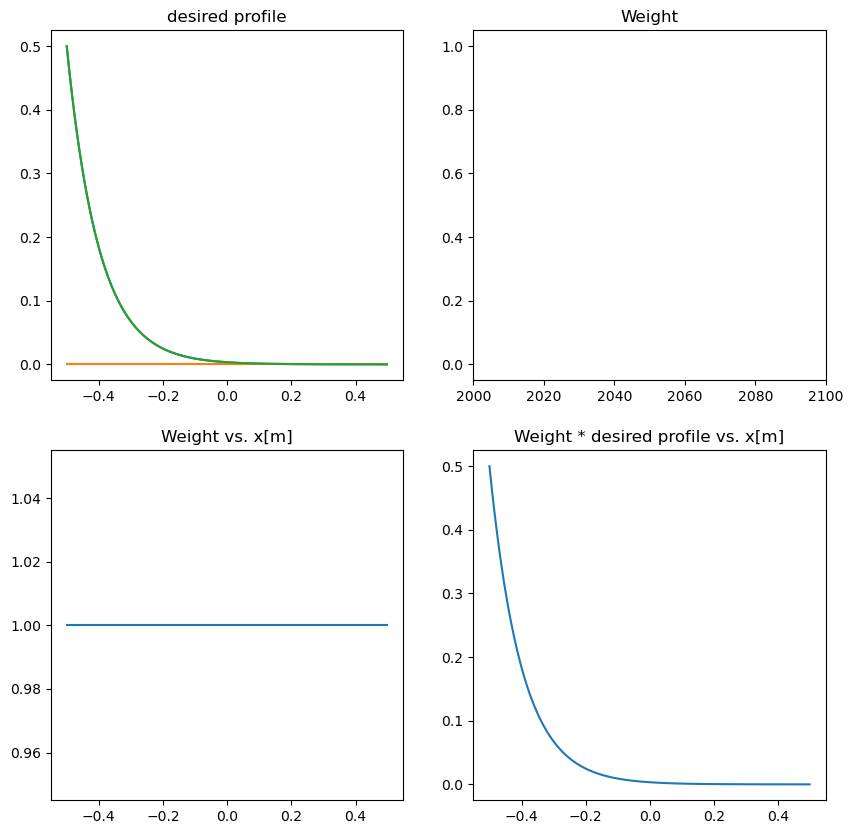

In [353]:
%matplotlib inline

N = 255
tb = 40 # npoints in pulse, tb of pulse
dt = 4e-6 # seconds, sampling rate
os = 2 # spatial oversampling factor
d1 = 0.01
d2 = 0.01 # ripple levels in beta profile

dthick = 4 # slice thickness in cm

# set mag of gamgdt according to tb + dthick
gambar = 4257 # Hz/g
gmag = tb/(N*dt)/dthick/gambar # G/cm
gmag_kHzcm = gmag * gambar

print("Amplitude in G/cm: gmag=%f" %gmag)
print("Amplitude in Hz/cm: gmag_kHzcm=%f" %gmag_kHzcm)
print("Pulse duration: N*dt=%f" %(N*dt*1000.0))

# get spatial locs + gradient
x = np.arange(0,N*os,1)/N/os-1/2

# gradient:
gamgdt = 2*np.pi*gambar*gmag*dt*np.ones(N)

# set gradient to 0:
# gamgdt = np.zeros_like(gamgdt)

# set up target beta pattern
d1 = np.sqrt(d1/2) # Mxy -> beta ripple for ex pulse
d2 = d2/np.sqrt(2)
dib = rf.slr.dinf(d1,d2);

ftwb = dib/tb;
fb = np.asarray([0, (1-ftwb)*(tb/2), (1+ftwb)*(tb/2), N/2])/N; # freq edges, normalized to 2*nyquist
print("dib=%f" %dib)
print("ftwb=%f" %ftwb)

dpass = np.abs(x) < fb[1] # passband mask
dstop = np.abs(x) > fb[2] # stopband mask
wb = [1, d1/d2]



# Weights:
# -----------------------------
w = dpass + wb[1]/wb[0]*dstop # 'points we care about' mask
w = np.ones_like(dpass)
w = np.zeros_like(dpass)
# w[int(len(w)/2):-1] = 1
w[0:int(len(w)/4)] = 1
w = np.ones_like(w)
# w = np.linspace(10, 0, 2*N)


# Magnetization profile:
# -----------------------------
# db = np.sqrt(1/2)*dpass*np.exp(-1j/2*x*2*np.pi) # target beta pattern

# Gaussian:
# db = norm.pdf(x,0,0.05)
# db = db / np.max(db) / 2.0

# exponential:
db = np.exp(-np.linspace(0, 2*N-1, 2*N)/(2*N-1) / 0.1)
# db = np.fft.fftshift(db)
db = db / np.max(db) / 2.0



plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(x,np.real(db))
plt.plot(x,np.imag(db))
plt.plot(x,np.abs(db))
plt.title('desired profile')
plt.subplot(2,2,2)
plt.plot(w)
plt.plot(np.abs(db))
plt.xlim((2000,2100))
plt.title('Weight')
plt.subplot(2,2,3)
plt.plot(x,w)
plt.title('Weight vs. x[m]')
plt.subplot(2,2,4)
plt.plot(x,w*np.abs(db))
plt.title('Weight * desired profile vs. x[m]')


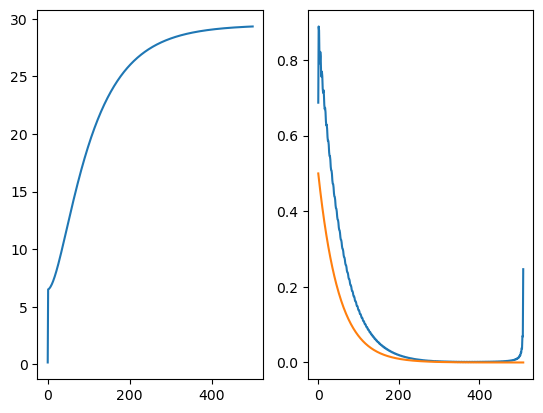

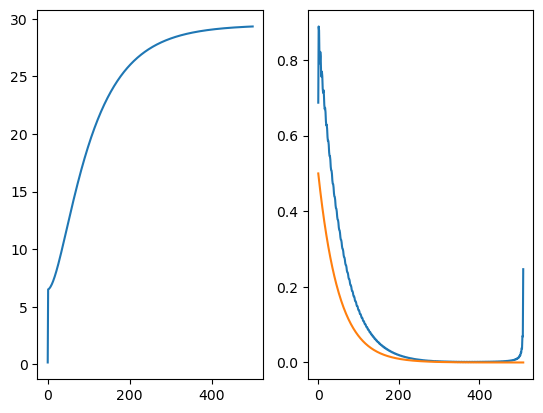

In [354]:
from IPython import display

# small function to calculate the cost:
def cost_calcer(pulse_shape_desired=None, pulse_shape_result=None, a=0, b=0):
    if pulse_shape_result is None:
        pulse_shape_result = 2*np.conj(a)*b
    diff = pulse_shape_result- pulse_shape_desired    
    return diff

# init parameters:
eb = b - db
stepsize = 0.0001
iters = 500

# init empty arrays:
pulse = np.zeros(N, dtype=complex)
a = np.exp(1j/2*x/(gambar*dt*gmag)*np.sum(gamgdt))
b = np.zeros(a.shape, dtype=complex)
cost = np.zeros(iters+1)
cost[0] = np.real(np.sum(w*np.abs(eb)**2))

# plot parameters:
fig, axlist = plt.subplots(1,2)
pass_yes_no = True

# Iterate
for ii in range(0, iters, 1):
    # abortion criterium
    if pass_yes_no == True:
        # calculate search direction
        
        # magnitude
        auxb = w*(b - db)
        
        # angle?
        auxa = w*(a - np.angle(db))
        auxa = None
        drf = rf.optcont.deriv(pulse, x/(gambar*dt*gmag), gamgdt, 0, auxb, a, b)
        # was like that before, better results without
        # drf = 1j*np.imag(drf)
        
        # get test point
        pulse -= stepsize*drf
        
        # simulate test point
        [a,b] = rf.optcont.blochsim(rf=pulse, x=x/(gambar*dt*gmag), g=gamgdt)
        
        # calculate difference
        eb = b - db
        # new way:
        eb = cost_calcer(pulse_shape_desired=db,
                         pulse_shape_result=None,
                         a=a,
                         b=b)

        # calulate cost:
        cost[ii+1] = np.sum(w*np.abs(eb)**2)
        # print(cost[ii]-cost[ii+1])

        # plotting:--------------------------------------------------------------
        axlist[0].clear()
        axlist[0].plot(cost)

        
        Mxy = 2*np.conj(a)*b
        Mxy_inv = np.fft.fftshift(np.fft.fft(Mxy))
        Mxy_approx = np.fft.ifftshift(np.fft.fftshift(np.fft.ifft(Mxy_inv)))
        
        axlist[1].clear()
        axlist[1].plot(np.abs(Mxy_approx))
        axlist[1].plot(np.abs(db))

        #ax1.title("diff cost = %f.5, %d / %d" %(cost[ii]-cost[ii+1], ii, iters))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        # plotting:--------------------------------------------------------------

        # check if cost differene is above threshold:
        if abs(cost[ii]-cost[ii+1]) > 1e-5:
            pass_yes_no = True
        else:
            pass_yes_no = False




#### Plot Results:

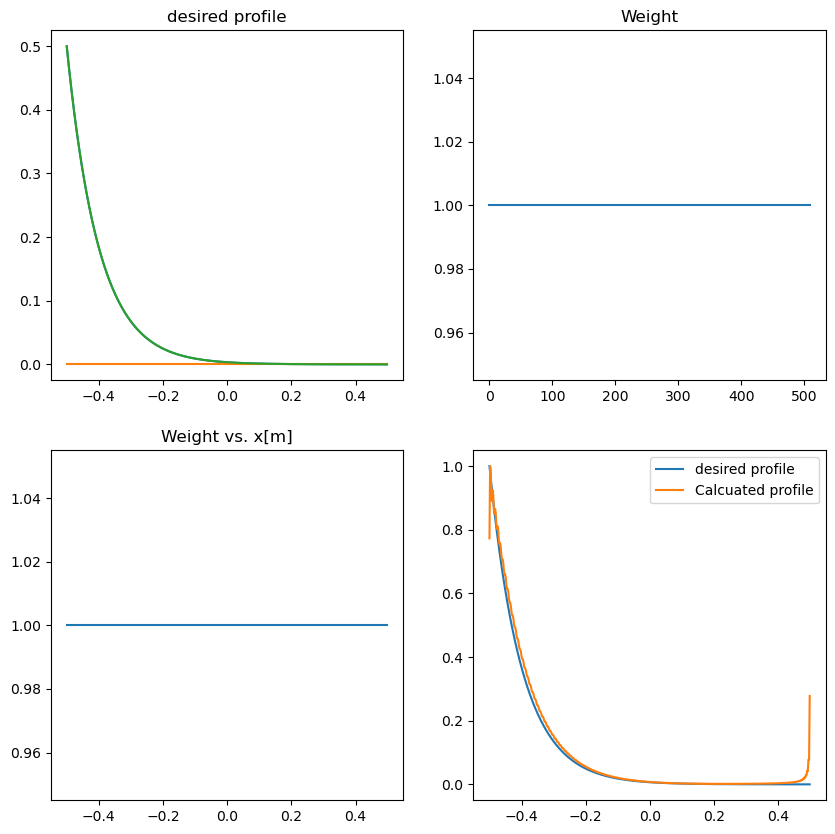

In [355]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(x,np.real(db),label='real')
plt.plot(x,np.imag(db),label='imaginary')
plt.plot(x,np.abs(db),label='Magnitude')
plt.title('desired profile')
plt.subplot(2,2,2)
plt.plot(w)
plt.title('Weight')
plt.subplot(2,2,3)
plt.plot(x,w)
plt.title('Weight vs. x[m]')
plt.subplot(2,2,4)
Mxy = 2*np.conj(a)*b
plt.plot(x,np.abs(db)/np.max(np.abs(db)),label='desired profile')
plt.plot(x,np.abs(Mxy)/np.max(np.abs(Mxy)),label='Calcuated profile')
plt.legend()
